In [1]:
import json
import numpy as np
from glob import glob

import torch
import os
from pathlib import Path
import shutil
from utils import plot_signal
from training import get_data, SwimNetSmall, inference, filter_signal
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# patients = glob('data/csv/all_test_clean/*') 

patients = [
    'data/csv/all_test_clean/014_2021_09_16_17_36_L_19281942004105_Breaststroke_25',
    'data/csv/all_test_clean/014_2021_09_16_17_47_L_19281942004105_freestroke_25',
    'data/csv/all_test_clean/czh-backstroke-5trips-p50',
    'data/csv/all_test_clean/why-P25_10trips_butterfly',
]
len(patients)


4

# Load Model

In [3]:
try_number = 1

try_dir = os.path.join('train', f'try_{try_number}')
parameters_path = os.path.join(try_dir, 'parameters.json')
model_path = os.path.join(try_dir, 'model.pth')
global_stats_path = os.path.join(try_dir, 'global_stats.json')
with open(global_stats_path, 'r') as f:
    global_stats = json.load(f)


# load parameters
if Path(parameters_path).exists():
    with open(parameters_path, 'r') as f:
        parameters = json.load(f)
    fc = parameters.get('fc')
    window_s = parameters.get('window_s')
    fs = parameters.get('fs')
    stride = parameters.get('stride', 25)
    n_channels = parameters.get('n_channels')
    cnn_filters = parameters.get('cnn_filters')
    gru_hidden = parameters.get('gru_hidden')
    p_drop = parameters.get('p_drop')
    n_classes = parameters.get('n_classes', 3)
    add_gyro = parameters.get('add_gyro', False)
else:
    raise FileNotFoundError(f"Parameters file not found: {parameters_path}")

device = "cuda" if torch.cuda.is_available() and torch.cuda.device_count() > 0 else "cpu"
model       = SwimNetSmall(n_channels=n_channels, p_drop=p_drop, cnn_filters=cnn_filters, gru_hidden=gru_hidden).to(device)
if Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print(f"Loaded model from {model_path}")
model.eval()


Loaded model from train/try_1/model.pth


SwimNetSmall(
  (conv1): Conv1d(9, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(32, 16, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
)

In [56]:
def extract_events(labels, class_id=2):
    """
    labels : 1-D np.array of ints
    returns list of (start_idx, end_idx) for contiguous blocks of class_id
    """
    on = labels == class_id
    # rising edges
    starts = np.where(np.diff(on.astype(int)) == 1)[0] + 1
    # falling edges
    ends   = np.where(np.diff(on.astype(int)) == -1)[0] + 1

    if on[0]:          # started inside a turn
        starts = np.insert(starts, 0, 0)
    if on[-1]:         # ended inside a turn
        ends   = np.append(ends, len(labels))

    lengths = ends - starts

    return list(zip(starts, ends, lengths))
def match_events(gt, pr, tol_frames=0):
    """
    Match ground-truth and predicted events if their tolerance-expanded
    intervals overlap by ≥ 1 frame (i.e. any overlap).

    Parameters
    ----------
    gt : list of (start, end, …)     # end exclusive
    pr : list of (start, end, …)
    tol_frames : int
        Expand each interval on both sides by this many frames.
        E.g. tol_frames = 25  →  ±1 s slack at 25 Hz.

    Returns
    -------
    tp, fp, fn, matched_pairs
        matched_pairs : list of (g_idx, p_idx)
    """
    matched = []
    used_pr = np.zeros(len(pr), dtype=bool)

    for g_idx, g_evt in enumerate(gt):
        g_s, g_e = g_evt[0], g_evt[1]
        g_s_exp  = g_s - tol_frames
        g_e_exp  = g_e + tol_frames

        for p_idx, p_evt in enumerate(pr):
            if used_pr[p_idx]:
                continue
            p_s, p_e = p_evt[0], p_evt[1]

            # overlap ≥ 1 frame?
            if max(0, min(g_e_exp, p_e) - max(g_s_exp, p_s)) > 0:
                matched.append((g_idx, p_idx))
                used_pr[p_idx] = True
                break   # each GT event can match only one prediction

    tp = len(matched)
    fp = len(pr) - tp
    fn = len(gt) - tp
    return tp, fp, fn, matched

# get data

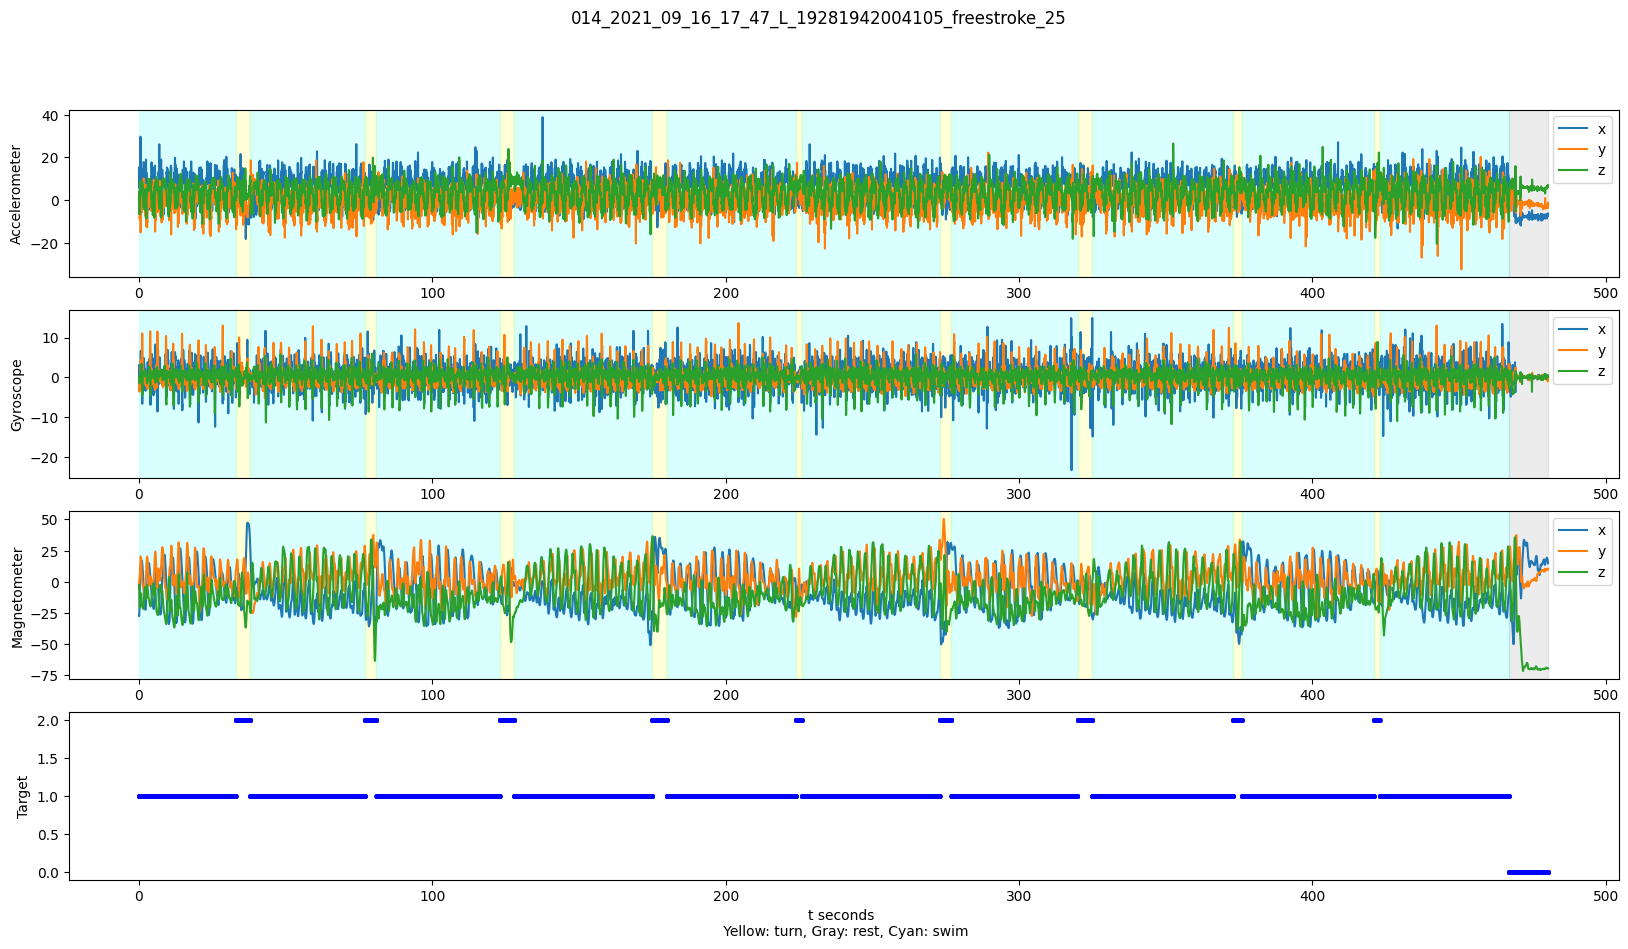

In [57]:
patient_path = patients[1]

patient_name = patient_path.split('/')[-1]
patient_dir = os.path.join(try_dir, 'patients', patient_name)
os.makedirs(patient_dir, exist_ok=True)

X, target = get_data(patient_path, add_gyro=add_gyro)
if add_gyro:
    plot_signal(X[:, :3], X[:, 3:6], X[:, 6:], target, title=patient_name, savepath=os.path.join(patient_dir, "signal_plot.png"))
    
else:
    plot_signal(X[:, :3], None, X[:, 3:], target, title=patient_name, savepath=os.path.join(patient_dir, "signal_plot.png"))


# inference

F1 Score: 0.5710


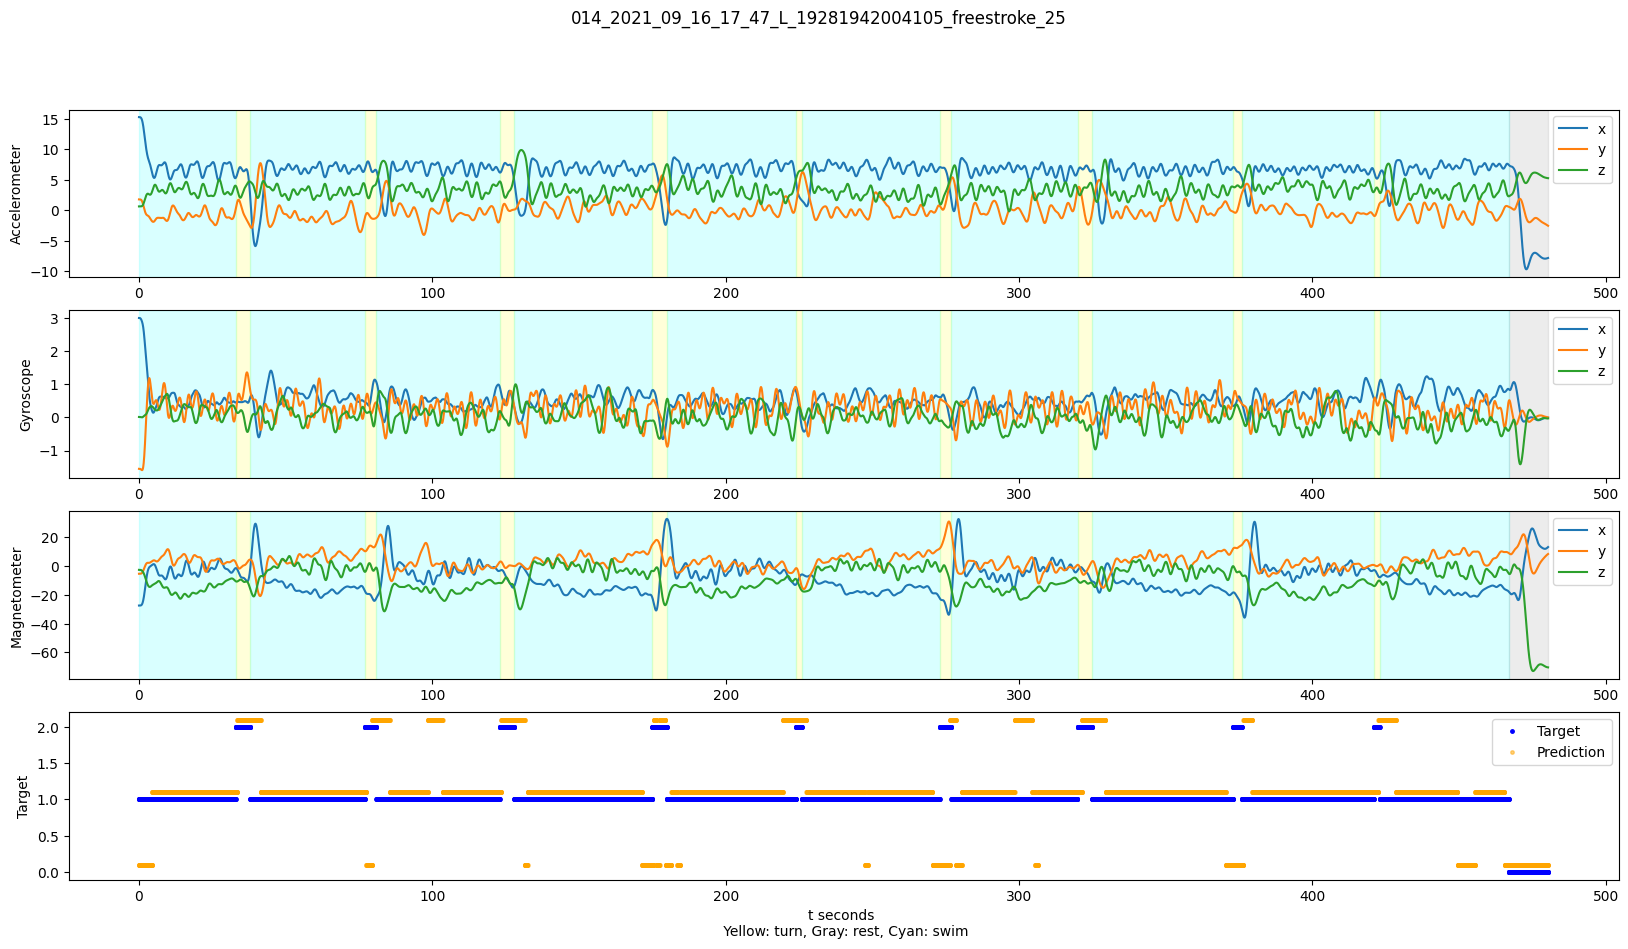

In [58]:

X_filt = filter_signal(X, fc=fc, fs=fs)
y_pred = inference(model, X_filt, global_stats, window=window_s * fs, stride=stride)
f1 = f1_score(target, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")



if add_gyro:
    plot_signal(X_filt[:, :3], X_filt[:, 3:6], X_filt[:, 6:], target, prediction=y_pred, title=patient_name)
else:
    plot_signal(X_filt[:, :3], None, X_filt[:, 3:], target, prediction=y_pred, title=patient_name)



In [59]:
pr_turns

[(838, 1038, 200),
 (1988, 2138, 150),
 (2463, 2588, 125),
 (3088, 3288, 200),
 (4388, 4413, 25),
 (4438, 4488, 50),
 (5488, 5688, 200),
 (6913, 6963, 50),
 (7463, 7613, 150),
 (8038, 8238, 200),
 (9413, 9488, 75),
 (10563, 10713, 150)]

Turns  P:0.750  R:1.000  F1:0.857
Count error: 3,  Mean timing error: 2.10 s


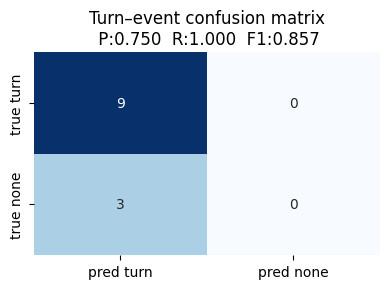

In [61]:
gt_turns = extract_events(target, class_id=2)
pr_turns = extract_events(y_pred, class_id=2)

tp, fp, fn, pairs = match_events(gt_turns, pr_turns, tol_frames=25)
precision = tp / (tp + fp + 1e-9)
recall    = tp / (tp + fn + 1e-9)
f1        = 2*precision*recall / (precision+recall+1e-9)
count_err = abs(len(gt_turns) - len(pr_turns))
timing_err = np.mean([abs(pr_turns[p][0] - gt_turns[g][0]) for g,p in pairs])

print(f"Turns  P:{precision:.3f}  R:{recall:.3f}  F1:{f1:.3f}")
print(f"Count error: {count_err},  Mean timing error: {timing_err/25:.2f} s")
# plot confusion matrix for turns
# --------- build a 2×2 event-level matrix -----------------
event_cm = np.array([[tp, fn],
                     [fp, 0]])        # TN is meaningless here

plt.figure(figsize=(4,3))
sns.heatmap(
    event_cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["pred turn", "pred none"],
    yticklabels=["true turn", "true none"],
    cbar=False
)
plt.title(f"Turn–event confusion matrix\n P:{precision:.3f}  R:{recall:.3f}  F1:{f1:.3f}")
plt.tight_layout()

In [62]:
pairs

[(0, 0), (1, 1), (2, 3), (3, 4), (4, 6), (5, 7), (6, 9), (7, 10), (8, 11)]

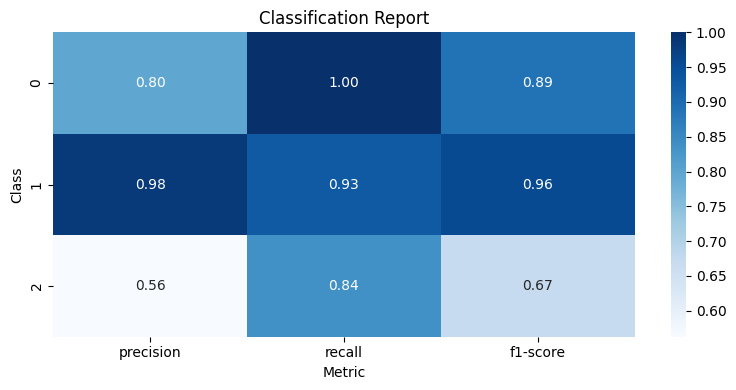

In [6]:

report = classification_report(
    target,
    y_pred,
    output_dict=True,
)

# Draw the classification report as a heatmap
# Convert classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Only keep precision, recall, f1-score for classes (not accuracy/support/avg)
class_names = [str(i) for i in range(len(report_df)-3)]
metrics = ['precision', 'recall', 'f1-score']
plot_df = report_df.loc[class_names, metrics]

plt.figure(figsize=(8, 4))
sns.heatmap(plot_df, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Classification Report")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()


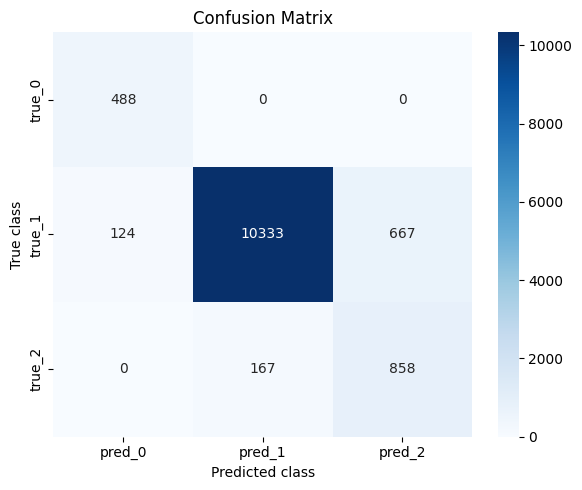

In [7]:

cm = confusion_matrix(
    target,
    y_pred,
    labels=list(range(n_classes))
)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"pred_{i}" for i in range(n_classes)],
    yticklabels=[f"true_{i}" for i in range(n_classes)]
)
plt.title("Confusion Matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()

# New data set 179

In [2]:
test_session_info_path_2 = '/home/zepp/users/Arman/swim/sessions_info_new_test_data.csv'
test_data_dir_2 = '/home/zepp/users/Arman/swim/data/csv/all_new_179_sessions/*'

In [3]:
session_info = pd.read_csv(test_session_info_path_2)


In [4]:
session_info

,filename,number_of_lengths
0,20230310165115_fly,12
1,20230310170255_back,8
2,20230310170945_breast,8
3,20230310171714_free,8
4,20230310172750_fly,8
...,...,...
174,0250105102905_free_8,8
175,0250105103541_fly_8,8
176,0250105104101_back_8,8
177,0250105104544_breast_8,8


In [56]:
results = []
patients = glob(test_data_dir_2)
for patient in patients:
    found = False
    # print('--')
    name = patient.split('/')[-1].split('_')
    date = [s for s in name if s.startswith('202')][0]
    date = date.split('(')[0]
    # print(date)
    for idx, session in session_info.iterrows():
        if date in session['filename'] or date[1:] in session['filename']:
            laps = session['number_of_lengths']
            # print(f"Found matching session: {len(session)}")
            # print(f"Number of laps: {laps}")
            result = {
                'filename': patient.split('/')[-1],
                'csv_filename': session['filename'],
                'laps': laps,
            }
            results.append(result)
            found = True
            break
    if not found:
        print(f"No matching session found for {patient.split('/')[-1]}")

# save as df
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)
